# Density Interpolation

It takes a very long time to run the density interpolation functions so I'm afraid a rewrite may be in order. This notebook will be used to:

1. understand how the functions work currently
2. constrain the amount of time it takes to run (scaling up from small samples)
3. rewrite to improve efficiency
4. test to ensure time savings

In [20]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import seaborn as sns
import seaborn
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [188]:
def func_var_int(ds, variable, rho_grid, dim1='N_PROF', dim2='PRES_INTERPOLATED', flag='group'):
    '''Takes an xarray and density grid, and returns an xarray in density space, with respect to the given variable
    
    ds: xarray in depth space
    variable: variable along which to convert to density
    rho_grid: density grid
    dim1: profiles dimension, default is N_PROF_NEW
    dim2: pressure dimension, default is PRES_INTERPOLATED
    flag: not totally sure
    '''
    
    N_PROF_num = ds[dim1].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho).compute(), drop=True).where(~np.isnan(ds[variable]).compute(), drop=True)
    
    var_nonan = ds[variable].where(~np.isnan(rho).compute(), drop=True).where(~np.isnan(ds[variable]).compute(), drop=True)
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan).compute(), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', dim1],
                        coords = {'rho_grid': rho_grid, dim1: [N_PROF_num]}).rename(variable)

In [189]:
def interpolate2density_prof(ds_z, rho_grid, dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    '''Takes an xarray in depth space and returns an xarray in density space, using the density grid provided.
    
    ds_z: xarray in depth space
    rho_grid: density grid that depth will be interpolated to
    dim1: profiles dimension, default is N_PROF_NEW to make plotting easier down the road
    dim2: pressure dimension, default is PRES_INTERPOLATED
    '''
    
    N_PROF_ind = 0
    PRES_INTERPOLATED_tilde_xr          = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES_INTERPOLATED',rho_grid)
    CT_tilde_xr                         = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT',rho_grid)
    SA_tilde_xr                         = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)
    SIG0_tilde_xr                       = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)
    SPICE_tilde_xr                      = func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)
    

    for N_PROF_ind in range(1, len(ds_z.N_PROF)):
        if np.mod(N_PROF_ind, 100)==0:
            print('Completed profile {}'.format(N_PROF_ind))
        PRES_INTERPOLATED_tilde_xr      = xr.concat([PRES_INTERPOLATED_tilde_xr,  func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'PRES_INTERPOLATED', rho_grid)], dim=dim1)
        CT_tilde_xr                     = xr.concat([CT_tilde_xr,    func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'CT', rho_grid)], dim=dim1)
        SA_tilde_xr                     = xr.concat([SA_tilde_xr,    func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SA', rho_grid)], dim=dim1)
        SIG0_tilde_xr                   = xr.concat([SIG0_tilde_xr,  func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SIG0', rho_grid)], dim=dim1)
        SPICE_tilde_xr                  = xr.concat([SPICE_tilde_xr, func_var_int(ds_z.isel(N_PROF=N_PROF_ind), 'SPICE', rho_grid)], dim=dim1)

    ds_rho = xr.merge([PRES_INTERPOLATED_tilde_xr, CT_tilde_xr,
                             SA_tilde_xr, SIG0_tilde_xr, SPICE_tilde_xr])
    
    ds_rho = ds_rho.assign_coords(TIME      =('N_PROF_NEW',ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =('N_PROF_NEW',ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =('N_PROF_NEW',ds_z.LONGITUDE.data))
    
    return ds_rho

## Small Time Test

In [5]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))

In [33]:
ds_100 = ds.isel(N_PROF=slice(10000,10100))
ds_200 = ds.isel(N_PROF=slice(10000,10200))
ds_500 = ds.isel(N_PROF=slice(10000,10500))
ds_1000 = ds.isel(N_PROF=slice(10000,11000))

In [34]:
rho_grid = np.arange(21,29,0.0025)

In [190]:
%%time
ds_100_rho_norm = interpolate2density_prof(ds_100, rho_grid)

CPU times: user 1min 37s, sys: 5.05 s, total: 1min 42s
Wall time: 1min 37s


In [37]:
print(f'Time to complete all profiles: {(((1*60+30)/100)*2550000)/60/60} hours')

Time to complete all profiles: 637.5 hours


In [36]:
%%time
ds_200_rho = interpolate2density_prof(ds_200, rho_grid)

Completed profile 100
CPU times: user 3min 4s, sys: 11.3 s, total: 3min 16s
Wall time: 3min 7s


In [38]:
print(f'Time to complete all profiles: {(((3*60+7)/200)*2550000)/60/60} hours')

Time to complete all profiles: 662.2916666666666 hours


In [39]:
%%time
ds_500_rho = interpolate2density_prof(ds_500, rho_grid)

Completed profile 100
Completed profile 200
Completed profile 300
Completed profile 400
CPU times: user 7min 52s, sys: 51.1 s, total: 8min 43s
Wall time: 8min 13s


In [40]:
print(f'Time to complete all profiles: {(((8*60+13)/500)*2550000)/60/60} hours')

Time to complete all profiles: 698.4166666666666 hours


In [41]:
%%time
ds_1000_rho = interpolate2density_prof(ds_1000, rho_grid)

Completed profile 100
Completed profile 200
Completed profile 300
Completed profile 400
Completed profile 500
Completed profile 600
Completed profile 700
Completed profile 800
Completed profile 900
CPU times: user 16min 34s, sys: 2min 37s, total: 19min 11s
Wall time: 18min 3s


In [42]:
print(f'Time to complete all profiles: {(((18*60+3)/1000)*2550000)/60/60} hours')

Time to complete all profiles: 767.125 hours


In [43]:
x = [100, 200, 500, 1000]
y_1 = [1*60+30, 3*60+7, 8*60+13, 18*60+3]
y_2 = [637.5, 662.3, 698.4, 767.1]

Text(0, 0.5, 'Time to complete all profiles (hours, extrapolated)')

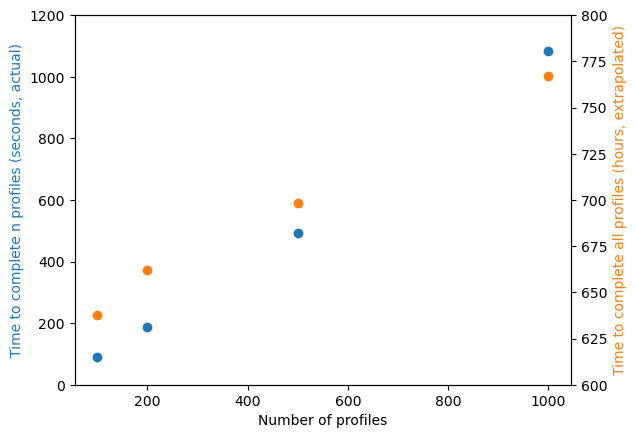

In [48]:
plt.scatter(x, y_1, color='tab:blue')
plt.ylim(0,1200)
plt.ylabel('Time to complete n profiles (seconds, actual)', color='tab:blue')
plt.xlabel('Number of profiles')
plt.twinx()
plt.scatter(x, y_2, color='tab:orange')
plt.ylim(600,800)
plt.ylabel('Time to complete all profiles (hours, extrapolated)', color='tab:orange')

## Rewrite 1: Structural rewrite of `interpolate2density`

In [65]:
def gpt_test(ds_z, rho_grid, dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    '''
    '''
    
    PRES_INTERPOLATED_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'PRES_INTERPOLATED', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    PRES_INTERPOLATED_xr = xr.combine_by_coords(PRES_INTERPOLATED_list)
    print('PRES_INTERPOLATED concat complete')
    
    CT_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'CT', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    CT_xr = xr.combine_by_coords(CT_list)
    print('CT concat complete')
    
    SA_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'SA', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    SA_xr = xr.combine_by_coords(SA_list)
    print('SA concat complete')
    
    SIG0_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'SIG0', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    SIG0_xr = xr.combine_by_coords(SIG0_list)
    print('SIG0 concat complete')
    
    SPICE_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), 'SPICE', rho_grid) for N_PROF in range(len(ds_z[dim1]))]
    SPICE_xr = xr.combine_by_coords(SPICE_list)
    print('SPICE concat complete')

    ds_rho = xr.merge([PRES_INTERPOLATED_xr, CT_xr, SA_xr, SIG0_xr, SPICE_xr])
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [66]:
%%time
ds_100_rho = gpt_test(ds_100, rho_grid)

PRES_INTERPOLATED concat complete
CT concat complete
SA concat complete
SIG0 concat complete
SPICE concat complete
CPU times: user 1min 36s, sys: 4.62 s, total: 1min 40s
Wall time: 1min 35s


In [68]:
print(f'Original function: {1*60+30} seconds')
print(f'gpt_test function: {1*60+35} seconds')

Original function: 90 seconds
gpt_test function: 95 seconds


In [69]:
%%time
ds_200_rho = gpt_test(ds_200, rho_grid)

PRES_INTERPOLATED concat complete
CT concat complete
SA concat complete
SIG0 concat complete
SPICE concat complete
CPU times: user 3min 18s, sys: 11.5 s, total: 3min 30s
Wall time: 3min 18s


In [70]:
print(f'Original function: {3*60+7} seconds')
print(f'gpt_test function: {3*60+18} seconds')

Original function: 187 seconds
gpt_test function: 198 seconds


In [74]:
def gpt_loop(ds_z, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    '''
    '''
    xrs = []
    
    for var in variables:
        var_list = [func_var_int(ds_z.isel(N_PROF=N_PROF), var, rho_grid)
                     for N_PROF in range(len(ds_z[dim1]))]
        var_xr = xr.combine_by_coords(var_list)
        xrs.append(var_xr)
        print(f'{var} concat complete')
    
    ds_rho = xr.merge(xrs)
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [75]:
%%time
ds_100_rho = gpt_loop(ds_100, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE'])

PRES_INTERPOLATED concat complete
CT concat complete
SA concat complete
SIG0 concat complete
SPICE concat complete
CPU times: user 1min 37s, sys: 4.55 s, total: 1min 41s
Wall time: 1min 36s


In [78]:
print(f'Original function: {1*60+30} seconds')
print(f'gpt_test function: {1*60+35} seconds')
print(f'gpt_loop function: {1*60+36} seconds')

Original function: 90 seconds
gpt_test function: 95 seconds
gpt_loop function: 96 seconds


In [ ]:
%%time
ds_200_rho = gpt_loop(ds_200, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE'])

In [79]:
print(f'Original function: {3*60+7} seconds')
print(f'gpt_test function: {3*60+18} seconds')
print(f'gpt_loop function: {3*60+16} seconds')

Original function: 187 seconds
gpt_test function: 198 seconds
gpt_loop function: 196 seconds


I think these functions are more simply written, however they don't lead to any meaningful decrease in computation time. If anything, they are slightly slower than the original function. I think I'm going to turn my focus to the other function now and see if that can produce meaningful time reductions.

## Rewrite 2: Looking at `func_var_int`

In [81]:
def func_var_int(ds, variable, rho_grid, dim1='N_PROF', dim2='PRES_INTERPOLATED', flag='group'):
    '''Takes an xarray and density grid, and returns an xarray in density space, with respect to the given variable
    
    ds: xarray in depth space
    variable: variable along which to convert to density
    rho_grid: density grid
    dim1: profiles dimension, default is N_PROF_NEW
    dim2: pressure dimension, default is PRES_INTERPOLATED
    flag: not totally sure
    '''
    
    N_PROF_num = ds[dim1].values
    
    rho = ds.SIG0
    rho_nonan = rho.where(~np.isnan(rho), drop=True)
    
    var_nonan = ds[variable].where(~np.isnan(rho), drop=True)
    var_nonan2 = var_nonan.where(~np.isnan(var_nonan), drop=True)
    
    if flag == 'group': # incase density is identical b/w two points (this makes things very slow)
        var_nonan = var_nonan.groupby(rho_nonan).mean()
        rho_nonan = rho_nonan.groupby(rho_nonan).mean()
    
    if (len(rho_nonan)>2) & (len(var_nonan2)>2):
        fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    
        var_tilde = fvar(rho_grid)
    else:
        var_tilde = np.nan*rho_grid
    
    return xr.DataArray(var_tilde.reshape((-1,1)),
                        dims = ['rho_grid', dim1],
                        coords = {'rho_grid': rho_grid, dim1: [N_PROF_num]}).rename(variable)

In [82]:
%%time
ds_100_rho = interpolate2density_prof(ds_100, rho_grid)

KeyError: 'Indexing with a boolean dask array is not allowed. This will result in a dask array of unknown shape. Such arrays are unsupported by Xarray.Please compute the indexer first using .compute()'

## Going to try a systemic rewrite with apply_func

In [158]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [211]:
def gpt_loop_interp(ds_z, rho_grid, variables, dim1='N_PROF', dim2='PRES_INTERPOLATED'):
    '''
    '''
    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, ds_z.SIG0, ds_z[var],
            input_core_dims=[['PRES_INTERPOLATED'], ['PRES_INTERPOLATED']],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_100[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    
    return ds_rho

In [206]:
%%time
ds_100_rho = gpt_loop_interp(ds_100, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE']).compute()

Completed PRES_INTERPOLATED
Completed CT
Completed SA
Completed SIG0
Completed SPICE
CPU times: user 794 ms, sys: 416 ms, total: 1.21 s
Wall time: 843 ms


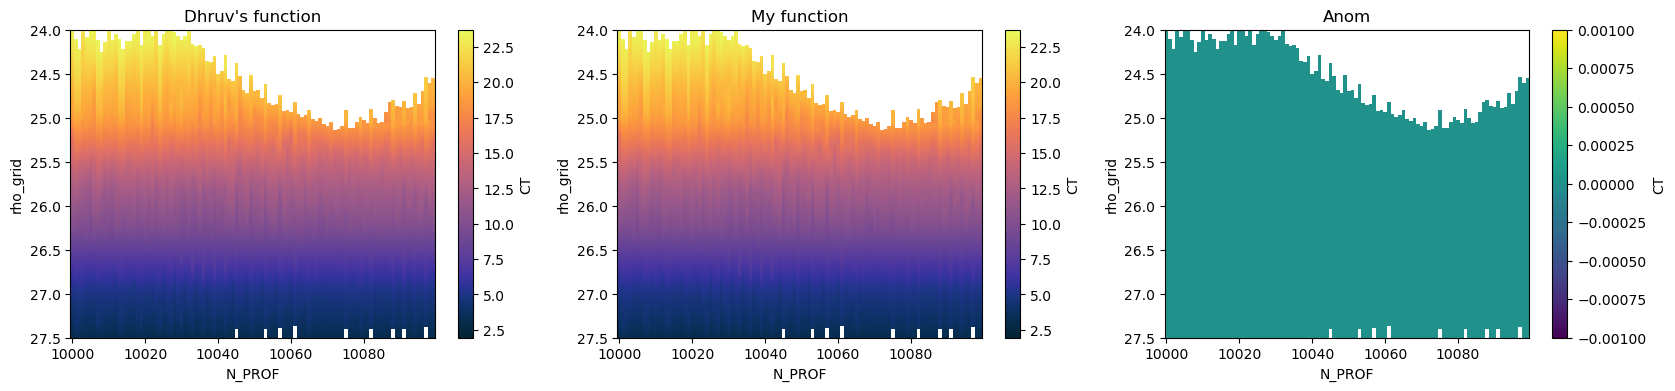

In [209]:
plt.figure(figsize=(20,4))

plt.subplot(131)
ds_100_rho.CT.plot(x='N_PROF', y='rho_grid', cmap=cmo.thermal)
plt.ylim(27.5,24)
plt.title("Dhruv's function")

plt.subplot(132)
ds_100_rho_norm.CT.plot(x='N_PROF', y='rho_grid', cmap=cmo.thermal)
plt.ylim(27.5,24)
plt.title("My function")

plt.subplot(133)
(ds_100_rho.CT - ds_100_rho_norm.CT).plot(x='N_PROF', y='rho_grid', vmin=-0.001, vmax=0.001)
plt.ylim(27.5,24)
plt.title("Anom");

In [214]:
from dask.distributed import Client, LocalCluster

# Set up a LocalCluster with more workers and threads
cluster = LocalCluster(
    n_workers=65,           # number of worker processes (usually = number of cores)
    threads_per_worker=1,  # number of threads per worker
    memory_limit='auto'    # or set like '4GB' per worker
)

client = Client(cluster)
client

In [212]:
%%time
ds_rho = gpt_loop_interp(ds, rho_grid, ['PRES_INTERPOLATED', 'CT', 'SA', 'SIG0', 'SPICE'])

Completed PRES_INTERPOLATED
Completed CT
Completed SA
Completed SIG0
Completed SPICE
CPU times: user 72.2 ms, sys: 73.6 ms, total: 146 ms
Wall time: 142 ms


In [214]:
%%time
ds_rho.load()

ERROR! Session/line number was not unique in database. History logging moved to new session 953



KeyboardInterrupt

